Notebook del modelo de árbol de decisión del dataframe de las peleas sin ponderar

- **Tarea del backlog:** https://github.com/UCM-GIDIA-PD1/c2425-R4/issues/20#issue-2913499571
- **Propósito del código:** Árbol de clasificación para el dataframe de peleas sin ponderar (P1).
- **Autor(es):** Telmo Aracama.  
- **Descripción y uso:** Ejecutar para ver el resultado del modelo de árbol de clasificación en P1.

In [ ]:
#NO BORRAR ESTA CELDA!!!!!!!!!!!!!!!!

#Está muy bien comentado el notebook 

#Marca con un * al final las que ya estén solucionadas

#Solucionar:
#No hay un apartado específico de transformación de variables ni selección, en caso de no ser necesaria ninguna transformación ni selección comentalo tambien
#Aunque dices que no buscas que el modelo de un accuracy alto, sino que, buscas ver la influencia de las variables y demás, los árboles no se entienden nada, mira a ver si puedes
#hacer algo para que se vean mejor. Si ves que es imposible que se vean bien creo que es mejor que no los muestres
#Se ha cambiado un poco el conjunto de datos eliminando las peleas anteriores a 2010 ya que en estas todas las ganaba el peleador A, y se desbalanceaban mucho las clases. Ahora aunque siguen
#estando desbalanceadas, lo están bastante menos. Lo digo porque comentas algo sobre porcentajes y estos ya han variado.
#En la parte de ajuste de hiperparámetros en la memoria pone que se deben añadir al menos 2 estrategias, tu ahora mismo usas solo grid search. Añade otra estrategia, y para que no tengas que hacer otra
#vez todo el análisis, lo que puedes hacer es comparar el accuracy y el f1-score de los dos modelos que te salgan, te quedas con el mejor y ya de este si haces un estudio más detallado.

#Si no entiendes algo me preguntas por discord soy Andrés

### Indice del Notebook

* [Descripcion general del notebook](#descripcion-general-del-notebook)  
* [Carga y Preprocesamiento de los Datos](#carga-y-preprocesamiento-de-los-datos)  
* [Entrenamiento de los modelos](#entrenamiento-de-los-modelos)
* [Evaluacion del modelo](#evaluacion-del-modelo)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import random
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

### Descripcion general del notebook

En este notebook, se llevará a cabo un análisis utilizando el modelo de Random Forest para abordar el problema de clasificación con las peleas sin ponderar. El propósito principal de este proyecto es identificar las variables más significativas en el conjunto de datos, en lugar de centrarnos exclusivamente en la optimización del rendimiento del modelo. A lo largo del análisis, se seguirá un enfoque de dos fases:

- Modelo inicial sin ajuste de hiperparámetros: En la primera fase, se entrenará un modelo de Random Forest sin ajustar ningún hiperparámetro. Este modelo se utilizará para establecer una línea base y obtener una comprensión inicial de cómo las variables afectan la predicción. En este punto, el modelo funcionará con los valores predeterminados de los hiperparámetros, como la profundidad máxima del árbol y el número de estimadores.

- Ajuste de hiperparámetros: En la segunda fase, se llevará a cabo un ajuste de hiperparámetros mediante técnicas como la búsqueda en cuadrícula o la búsqueda aleatoria. Esto nos permitirá explorar diversas combinaciones de parámetros y observar cómo influyen en la capacidad del modelo para identificar las variables más relevantes. El objetivo aquí es mejorar la interpretación del modelo en lugar de optimizar la precisión en términos absolutos.

Un aspecto clave de este proyecto es el desbalance de clases en el conjunto de datos. Dado que las clases no están equilibradas, se utilizará el F1 score como la métrica principal para evaluar el rendimiento del modelo en lugar de la precisión (accuracy). El F1 score, que es la media armónica entre la precisión y la sensibilidad, es particularmente útil en situaciones de desbalance de clases porque tiene en cuenta tanto los falsos positivos como los falsos negativos, ofreciendo una evaluación más equilibrada de la capacidad del modelo para predecir correctamente las clases minoritarias.

El análisis realizado en este notebook no tiene como objetivo final alcanzar un alto *accuracy*, sino más bien entender las dinámicas de las variables y su impacto en el modelo. Al identificar las características más importantes, se puede obtener una visión más clara de qué factores están influyendo en la clasificación, lo que puede ser útil para futuras investigaciones o para mejorar modelos más complejos.

### Carga y Preprocesamiento de los Datos

En esta celda se cargan los conjuntos de datos de entrenamiento y prueba, que están almacenados en formato Parquet. Para ello, se utilizan las rutas relativas para acceder a los archivos en el sistema de archivos. Posteriormente, se eliminan las columnas irrelevantes para el análisis, como las relacionadas con la fecha, categoría, métodos de pelea y otros atributos específicos de los peleadores, como los nombres de los peleadores y el título de la pelea. El objetivo es reducir la complejidad de los datos y enfocarse solo en las características relevantes para el modelo, mejorando así el desempeño y la interpretabilidad del modelo posterior.

In [2]:
ruta_train = os.path.join("..","..","..", "data", "P1","train.parquet")
train = pd.read_parquet(ruta_train) 
train = train.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

ruta_test = os.path.join("..","..","..", "data", "P1","test.parquet")
test = pd.read_parquet(ruta_test) 
test = test.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

**División de las Características y la Variable Objetivo**

En esta celda, se separan las características (features) y la variable objetivo (target) en los conjuntos de datos de entrenamiento y prueba. La columna "WINNER", que representa la clase a predecir, se extrae y se asigna a las variables y_train y y_test. El resto de las columnas se asignan a X_train y X_test, que son las matrices de características para entrenar y evaluar el modelo. Este paso es fundamental para preparar los datos para el entrenamiento del modelo de clasificación.

In [3]:
X_train = train.drop(columns=["WINNER"])
y_train = train["WINNER"]

X_test = test.drop(columns=["WINNER"])
y_test = test["WINNER"]

En esta celda, se verifica la distribución de clases en los conjuntos de datos de entrenamiento y prueba. Para ello, se utiliza el método value_counts() de Pandas, que muestra la cantidad de instancias que corresponden a cada clase en cada uno de los conjuntos. Este análisis es crucial para identificar si las clases están desbalanceadas, lo cual puede afectar el rendimiento del modelo, especialmente si se usan métricas como la precisión (accuracy). En este caso, la variable de interés es "WINNER", que indica si el Peleador A o el Peleador B ha ganado la pelea. El objetivo de esta celda es evaluar si el modelo debe enfrentarse a un desbalance de clases y, en caso afirmativo, considerar estrategias para abordarlo, como ajustar el peso de las clases o aplicar técnicas de re-muestreo.

In [4]:
print("Distribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts())

print("\nDistribución de clases en el conjunto de prueba:")
print(y_test.value_counts())

Distribución de clases en el conjunto de entrenamiento:
WINNER
False    2691
True     2040
Name: count, dtype: int64

Distribución de clases en el conjunto de prueba:
WINNER
False    1179
True      849
Name: count, dtype: int64


Los resultados muestran un desbalance moderado en las clases de los dos conjuntos de datos. En el conjunto de entrenamiento, la clase "Peleador A gana" representa aproximadamente el 62.7%, mientras que "Peleador B gana" tiene un 37.3%. Este patrón se repite en el conjunto de prueba, con la clase mayoritaria ocupando alrededor del 63-64%. Este desbalance puede llevar a que el modelo favorezca la clase mayoritaria, afectando su capacidad para predecir correctamente la clase minoritaria. Es recomendable utilizar métricas como el F1-score o ajustar los pesos de las clases para mejorar el rendimiento en escenarios de desbalance.

### Entrenamiento de los modelos

**Entrenamiento del Árbol de Decisión Primitivo con Profundidad Limitada**

En esta sección, se entrena un modelo de árbol de decisión básico utilizando el parámetro max_depth=5 para limitar la profundidad máxima del árbol. Este modelo se entrena sin realizar ajustes adicionales de hiperparámetros, lo que nos permite obtener una referencia inicial del rendimiento del modelo. El objetivo es observar cómo se comporta el modelo con los datos de entrenamiento y, posteriormente, evaluar su desempeño en los conjuntos de validación y prueba utilizando el F1-score como métrica principal, dado que las clases están desbalanceadas. Este paso proporciona una base para comparar con los resultados obtenidos tras realizar ajustes más finos en los hiperparámetros.

Además, se muestran los reportes de clasificación para ambos conjuntos (validación y prueba), así como una visualización del árbol de decisión entrenado, lo que permite comprender las reglas y decisiones tomadas por el modelo.

F1-score en train: 0.8158

Clasificación (Train):
              precision    recall  f1-score   support

       False       0.84      0.90      0.87      2691
        True       0.86      0.78      0.82      2040

    accuracy                           0.85      4731
   macro avg       0.85      0.84      0.84      4731
weighted avg       0.85      0.85      0.85      4731

F1-score en test: 0.7635

Clasificación (Test):
              precision    recall  f1-score   support

       False       0.82      0.87      0.84      1179
        True       0.80      0.73      0.76       849

    accuracy                           0.81      2028
   macro avg       0.81      0.80      0.80      2028
weighted avg       0.81      0.81      0.81      2028



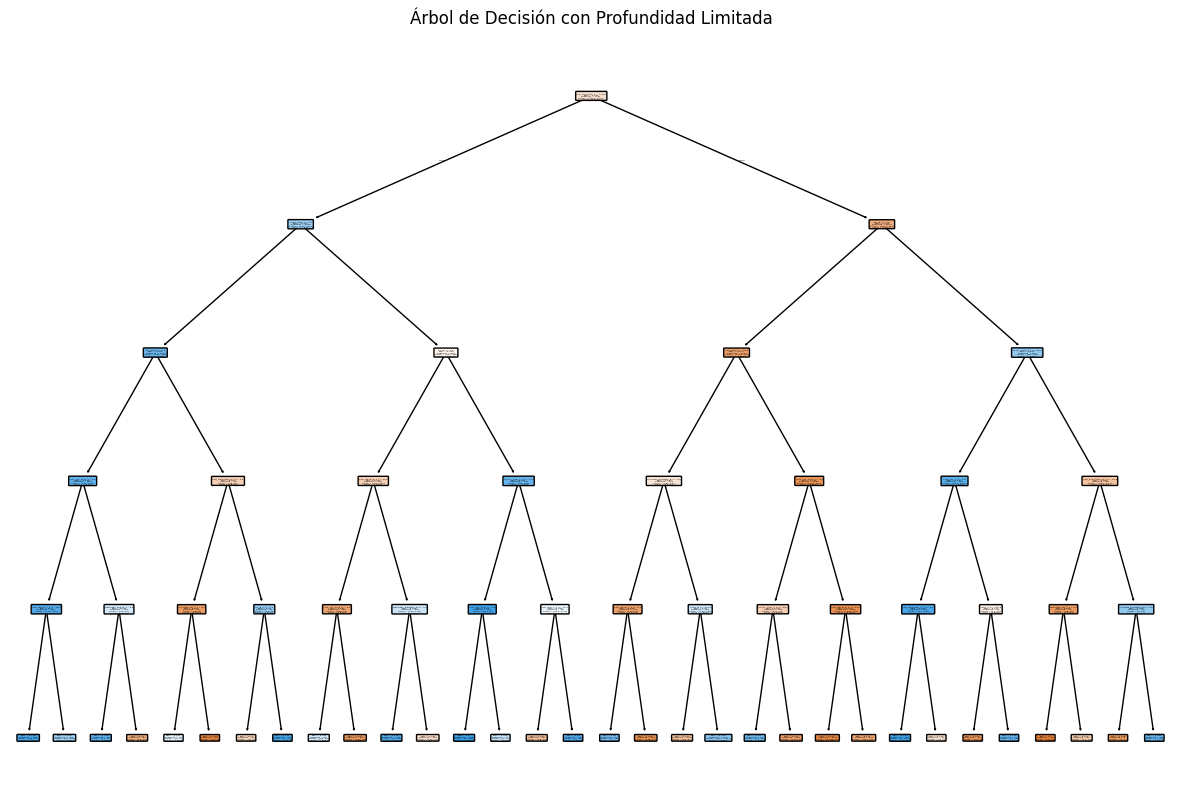

In [5]:
###### ARBOL DE DECISION PRIMITIVO CON LIMITACION DE LA PROFUNDIDAD #####

clf = DecisionTreeClassifier(random_state=42, max_depth=5)  # Ajusta el valor de max_depth según sea necesario
clf=clf.fit(X_train, y_train)

# Evaluar en validación
y_train_pred = clf.predict(X_train)
f1_val = f1_score(y_train, y_train_pred)
print(f'F1-score en train: {f1_val:.4f}')

print("\nClasificación (Train):")
print(classification_report(y_train, y_train_pred))

# Evaluar en test
y_test_pred = clf.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)
print(f'F1-score en test: {f1_test:.4f}')

print("\nClasificación (Test):")
print(classification_report(y_test, y_test_pred))

plt.figure(figsize=(15, 10))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["B gana", "A gana"], rounded=True)
plt.title("Árbol de Decisión con Profundidad Limitada")
plt.show()


Los resultados obtenidos con este primer modelo sin ajustes de hiperparámetros son bastante sólidos. Aunque no hemos realizado optimización alguna, la precisión es relativamente buena, lo que indica que el árbol de decisión, incluso en su forma básica, es capaz de realizar predicciones de manera razonablemente efectiva. Este desempeño inicial nos sirve como una referencia para evaluar las mejoras que alcanzaremos mediante el ajuste de los hiperparámetros. A medida que optimicemos el modelo, podremos medir de manera más precisa el impacto de estos cambios en la capacidad predictiva.

En esta sección, se obtiene la importancia de cada característica (o variable) en el árbol de decisión entrenado, utilizando el atributo feature_importances_. Luego, se crea un DataFrame que almacena las características junto con sus respectivas importancias, y se ordena en función de la relevancia de cada variable, de mayor a menor. El objetivo de este paso es identificar las variables que tienen un mayor impacto en la toma de decisiones del modelo.

C:\Users\andre\AppData\Local\Temp\ipykernel_22424\964556729.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Característica', data=feature_importance_df, palette='viridis')


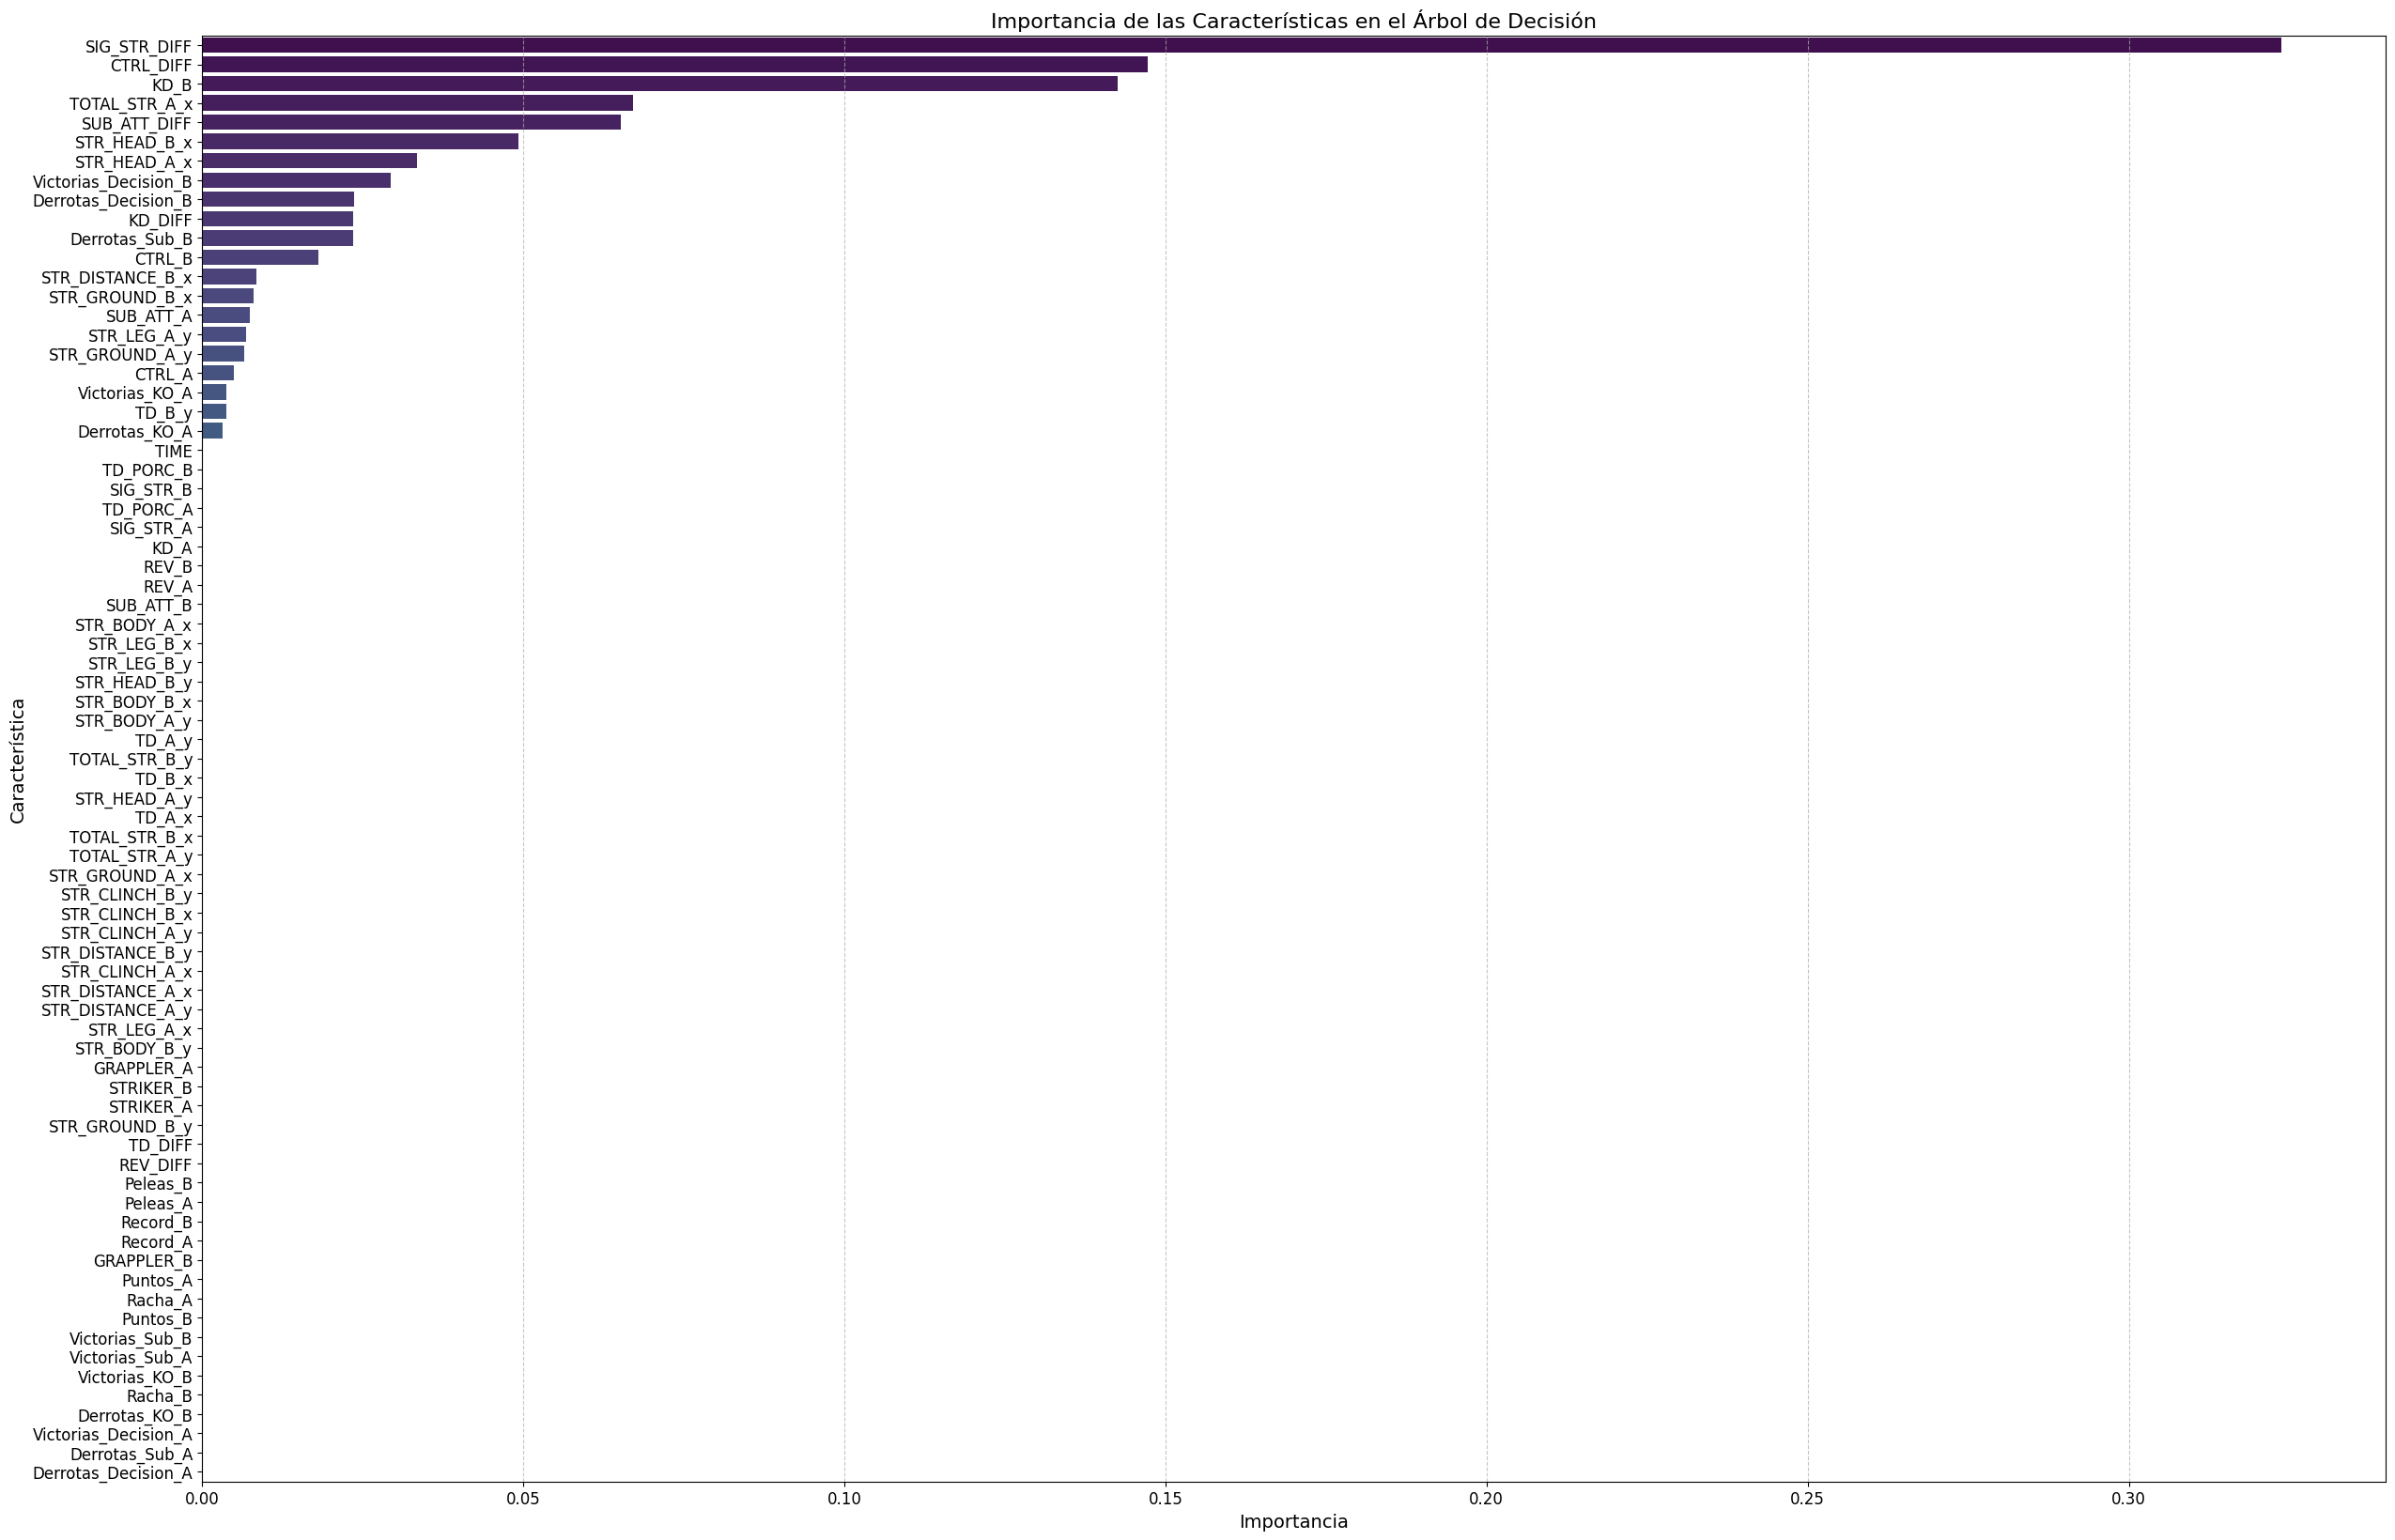

In [6]:
feature_importance = clf.feature_importances_

feature_importance_df = pd.DataFrame({'Característica': X_train.columns, 'Importancia': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(30, 20))  # Aumentamos el tamaño de la figura
sns.barplot(x='Importancia', y='Característica', data=feature_importance_df, palette='viridis')

plt.xlabel('Importancia', fontsize=14)
plt.ylabel('Característica', fontsize=14)
plt.title('Importancia de las Características en el Árbol de Decisión', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Agregar una rejilla sutil en el eje X

plt.show()


En el gráfico de barras se puede observar que el modelo ha asignado una importancia destacada a un número reducido de variables. Esto se debe a la profundidad limitada que hemos establecido para el árbol de decisión, lo que restringe su capacidad de capturar relaciones más complejas entre las características. Al limitar la profundidad del árbol, se evita el sobreajuste, pero también se reduce la cantidad de variables que el modelo puede considerar como relevantes. Este comportamiento resalta la necesidad de experimentar con diferentes profundidades en el árbol para evaluar cómo afecta la importancia de las características y el rendimiento general del modelo.

**Búsqueda de los Mejores Hiperparámetros con GridSearchCV**

En esta sección, realizamos una búsqueda exhaustiva de los mejores hiperparámetros para el modelo de árbol de decisión utilizando GridSearchCV. Definimos una amplia gama de hiperparámetros en el diccionario param_grid, que incluye opciones para la profundidad máxima del árbol, el número mínimo de muestras para dividir un nodo, el criterio de división, y otros aspectos que afectan la estructura del árbol. Usamos validación cruzada con 5 pliegues y el F1-score como métrica de evaluación debido al desbalance de clases en el problema.

Una vez realizado el ajuste, se selecciona el modelo con los mejores hiperparámetros encontrados. A continuación, evaluamos el rendimiento del modelo en el conjunto de prueba, calculando el F1-score. Finalmente, se muestran los reportes de clasificación y se visualiza el árbol de decisión resultante, lo que permite analizar cómo las características influyen en las decisiones del modelo con los parámetros óptimos.

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
F1-score en entrenamiento: 0.9288
F1-score en test: 0.8091

Reporte de clasificación (Train):
              precision    recall  f1-score   support

       False       0.94      0.96      0.95      2691
        True       0.94      0.91      0.93      2040

    accuracy                           0.94      4731
   macro avg       0.94      0.94      0.94      4731
weighted avg       0.94      0.94      0.94      4731


Reporte de clasificación (Test):
              precision    recall  f1-score   support

       False       0.86      0.88      0.87      1179
        True       0.82      0.80      0.81       849

    accuracy                           0.84      2028
   macro avg       0.84      0.84      0.84      2028
weighted avg       0.84      0.84      0.84      2028



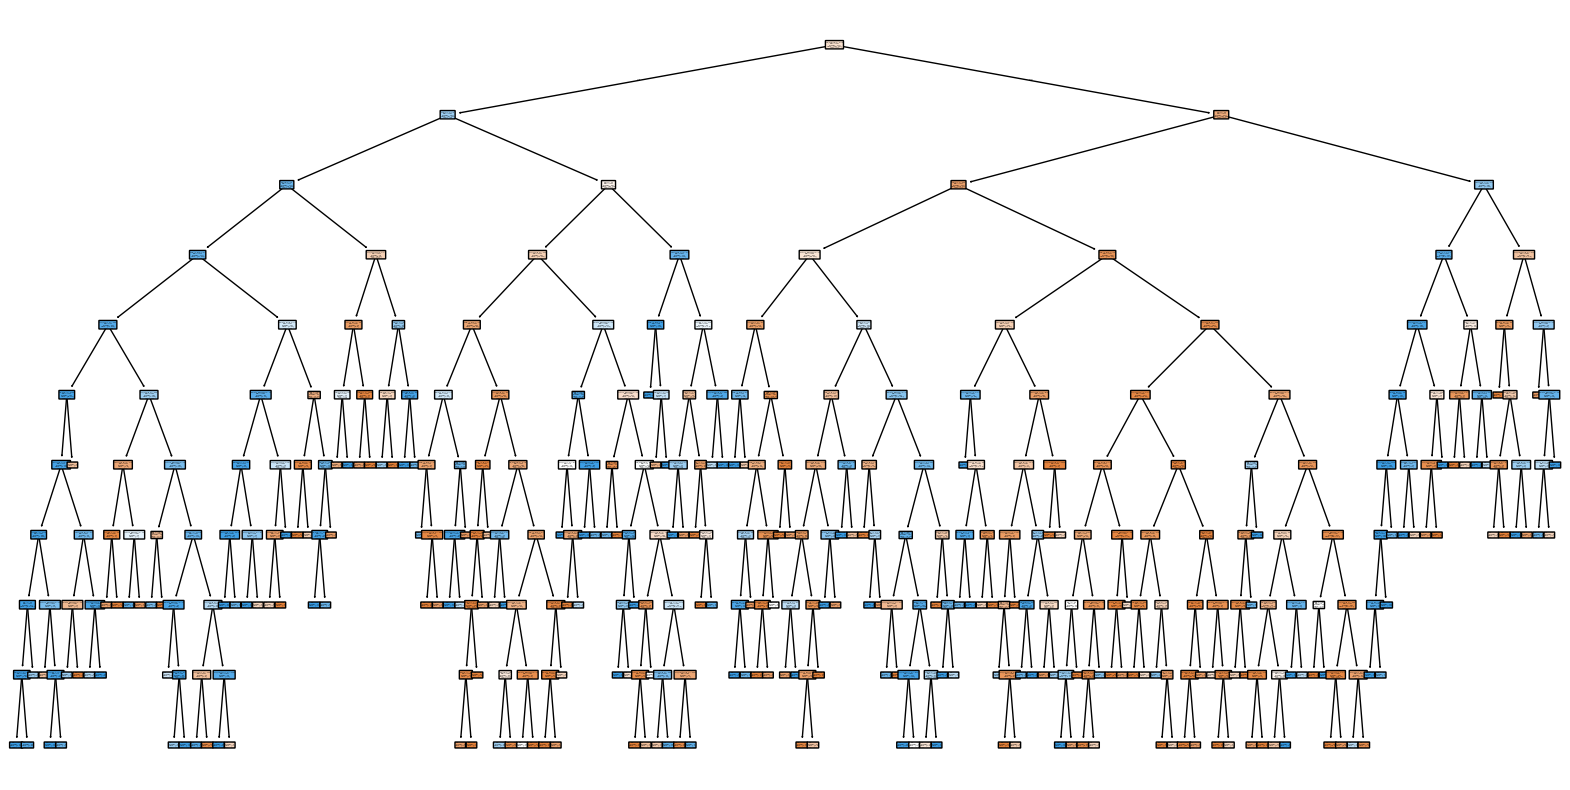

In [7]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
f1_val = f1_score(y_train, y_train_pred)
print(f'F1-score en entrenamiento: {f1_val:.4f}')

y_test_pred = best_model.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)
print(f'F1-score en test: {f1_test:.4f}')

print("\nReporte de clasificación (Train):")
print(classification_report(y_train, y_train_pred))

print("\nReporte de clasificación (Test):")
print(classification_report(y_test, y_test_pred))

plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=X_train.columns, class_names=["False", "True"], filled=True, rounded=True)
plt.show()


Después de realizar la selección de los mejores hiperparámetros mediante GridSearchCV, al evaluar el modelo optimizado, observamos una mejora en los resultados en comparación con el modelo inicial. Sin embargo, aunque el rendimiento ha mejorado, existen otros modelos que logran una mayor precisión en la predicción. Esto nos lleva a la conclusión de que, aunque los árboles de decisión son herramientas valiosas para identificar las características más importantes, no siempre son los mejores modelos en términos de precisión predictiva. A pesar de su capacidad para interpretar y visualizar las decisiones, su rendimiento puede verse limitado en comparación con otros algoritmos más complejos o especializados.

En esta sección, se realiza un estudio de la importancia de las variables utilizando el modelo de árbol de decisión seleccionado. El objetivo es identificar cuáles de las características o variables tienen un mayor impacto en la predicción del modelo. Este análisis nos ayuda a comprender mejor el comportamiento del modelo y a determinar qué factores son los más relevantes para predecir el resultado.

C:\Users\andre\AppData\Local\Temp\ipykernel_22424\3769561865.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Característica', data=feature_importance_df, palette='viridis')


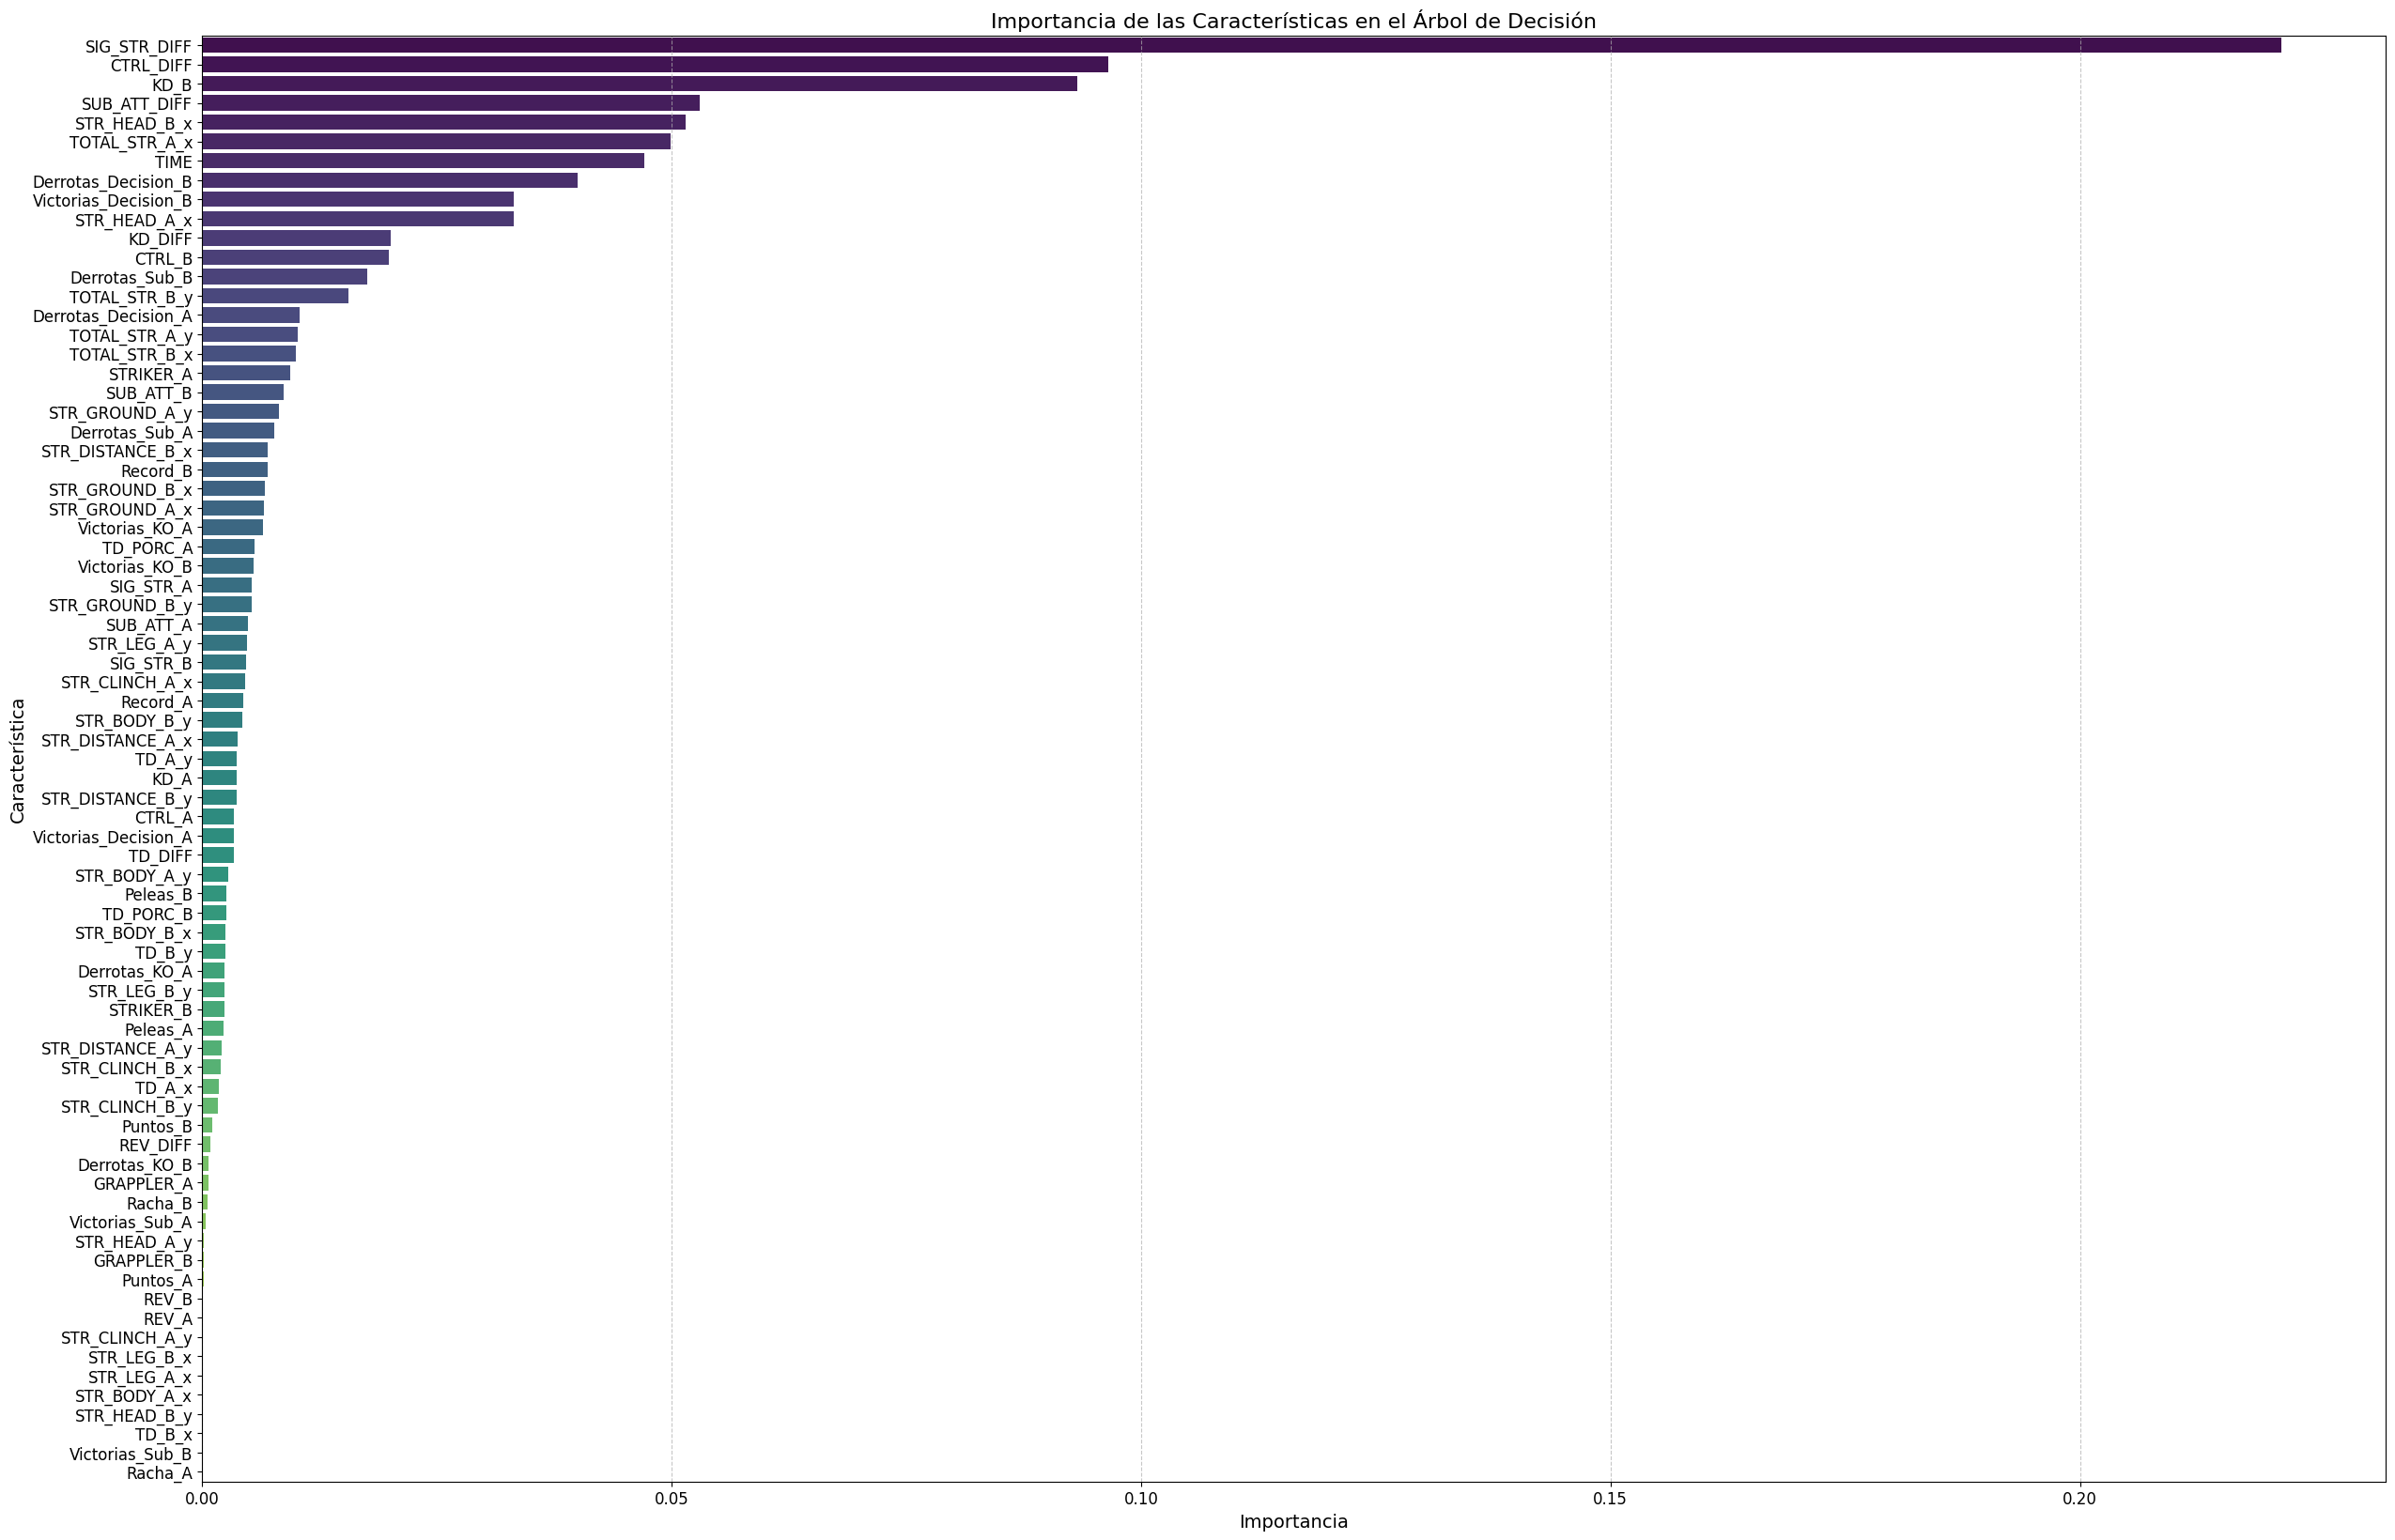

In [8]:
feature_importance = best_model.feature_importances_

feature_importance_df = pd.DataFrame({'Característica': X_train.columns, 'Importancia': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(30, 20))
sns.barplot(x='Importancia', y='Característica', data=feature_importance_df, palette='viridis')

plt.xlabel('Importancia', fontsize=14)
plt.ylabel('Característica', fontsize=14)
plt.title('Importancia de las Características en el Árbol de Decisión', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


En el gráfico de importancia de variables, podemos observar que algunas características tienen un peso considerable, mientras que otras son prácticamente ignoradas por el modelo. Este análisis es útil cuando decidimos realizar transformaciones para otros modelos, ya que nos permite identificar las variables más relevantes. Podemos optar por descartar aquellas con menor impacto y centrarnos en las que tienen mayor influencia en las decisiones del árbol. De esta forma, no solo optimizamos el modelo, sino que también reducimos su complejidad, lo que puede mejorar su capacidad de generalización y eficiencia al enfocarnos en los factores clave que realmente afectan las predicciones.

### Evaluacion del modelo

**Evaluación del Modelo mediante la Matriz de Confusión**

En esta sección, se calculan las predicciones del modelo optimizado sobre el conjunto de datos de prueba utilizando el método predict. A continuación, se calcula la matriz de confusión, que nos permite analizar cómo el modelo clasifica correctamente o incorrectamente las observaciones en las diferentes categorías. En este caso, las etiquetas corresponden a los peleadores "A" y "B".

La matriz de confusión se visualiza en un gráfico de fácil interpretación, donde cada celda muestra el número de observaciones clasificadas en cada categoría. Esta representación nos proporciona una visión clara de los aciertos y errores del modelo, lo que resulta útil para identificar posibles sesgos o áreas en las que el modelo podría mejorar.

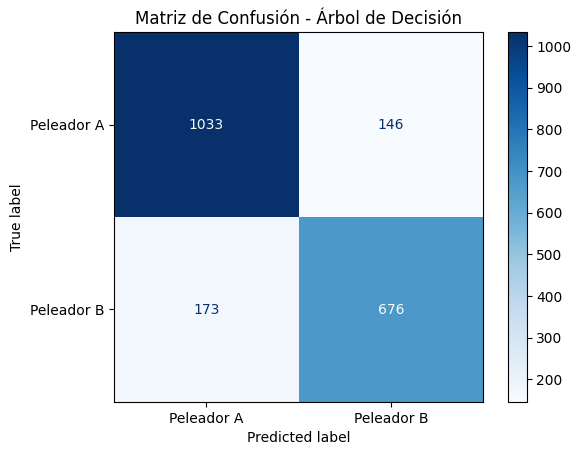

In [9]:
y_pred = best_model.predict(X_test)

# Calcular la matriz de confusion
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Peleador A", "Peleador B"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.show()


Se puede observar que el modelo comete más errores cuando el ganador es el Peleador B. Esto sugiere que, en muchos casos, el Peleador B no es considerado el favorito ni ha dominado significativamente el combate, pero ha logrado ganar debido a factores impredecibles, como un golpe de suerte o eventos aleatorios. Esta tendencia en los errores del modelo indica que podría tener dificultades para identificar situaciones en las que el resultado es menos predecible o está influenciado por elementos fuera del control del modelo. Es posible que, para mejorar la precisión, se requiera una mayor capacidad para capturar patrones complejos o eventos menos deterministas en los datos.

**Evaluación del Modelo con la Curva ROC**

En esta sección, calculamos las probabilidades de la clase positiva (en este caso, la clase "Peleador B") utilizando el método predict_proba del modelo optimizado. A continuación, se calcula la curva ROC (Receiver Operating Characteristic) utilizando las probabilidades obtenidas y las etiquetas reales del conjunto de prueba. La curva ROC muestra la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) para diferentes umbrales de decisión.

La métrica AUC (Area Under the Curve) se calcula como el área bajo la curva ROC, lo que proporciona una medida de la capacidad del modelo para discriminar entre las clases. Un valor de AUC cercano a 1 indica un modelo con buen poder predictivo, mientras que un valor cercano a 0.5 sugiere un rendimiento aleatorio. Finalmente, la curva ROC se visualiza en un gráfico, donde se traza la línea de referencia (diagonal) para comparar el rendimiento del modelo con un clasificador aleatorio.

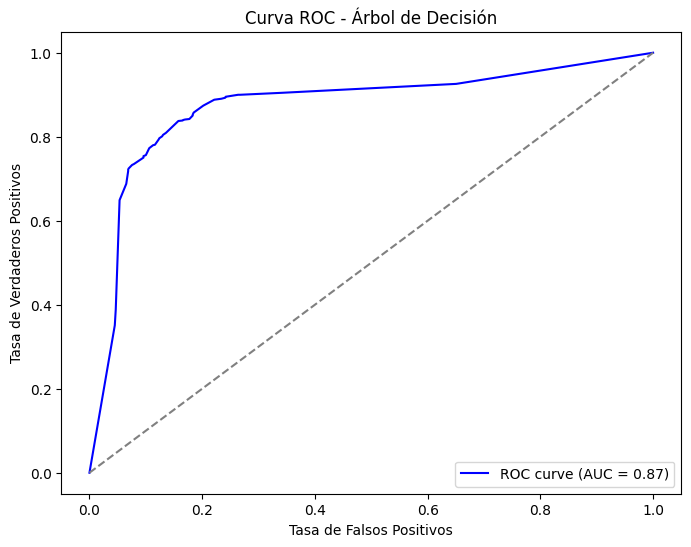

In [10]:
y_probs = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Árbol de Decisión')
plt.legend(loc='lower right')
plt.show()


En el gráfico de la curva ROC, se puede observar que la tasa de verdaderos positivos (TPR) sube rápidamente a un valor cercano a 0.8 al principio, lo que indica que el modelo logra identificar correctamente una gran proporción de las instancias positivas en las primeras etapas del proceso de clasificación. Posteriormente, la curva continúa subiendo de manera más gradual hasta acercarse a 1, lo que sugiere que el modelo mantiene un buen desempeño a medida que ajusta sus umbrales, alcanzando finalmente una excelente capacidad de discriminación. Este comportamiento es un buen indicativo de que el modelo tiene una alta capacidad para distinguir entre las clases, especialmente en la clase positiva.



**Evaluación del Modelo con un Ejemplo Aleatorio**

En esta sección, seleccionamos un índice aleatorio del conjunto de prueba para realizar una predicción sobre una pelea específica. A partir de este índice, extraemos las características de la pelea y obtenemos la etiqueta real correspondiente al ganador (Peleador A o Peleador B). A continuación, utilizamos el modelo optimizado para predecir el ganador de la pelea.

Se comparan el ganador real y el ganador predicho por el modelo para analizar cómo se desempeña el modelo en un caso individual. Mostrar este tipo de ejemplos aleatorios permite entender mejor el comportamiento del modelo en situaciones concretas, y proporciona una forma intuitiva de visualizar cómo el modelo toma decisiones.

In [11]:
random_index = random.randint(0, len(X_test) - 1)

pelea_ejemplo = X_test.iloc[random_index:random_index+1]  
pelea_real = y_test.iloc[random_index] 

prediccion = best_model.predict(pelea_ejemplo)[0]  

ganador_real = "Peleador B" if pelea_real else "Peleador A"
ganador_predicho = "Peleador B" if prediccion else "Peleador A"

print("===== PELEA ALEATORIA =====")
print(pelea_ejemplo)  
print("\nGanador Real: ", ganador_real)
print("Predicción del Modelo: ", ganador_predicho)


===== PELEA ALEATORIA =====
     TIME  KD_A  KD_B  SIG_STR_A  SIG_STR_B  TD_PORC_A  TD_PORC_B  SUB_ATT_A  \
760   300     0     0       0.65       0.73        0.2       0.71          0   

     SUB_ATT_B  REV_A  ...  Victorias_Sub_A  Victorias_Sub_B  \
760          0      1  ...                2                0   

     Victorias_Decision_A  Victorias_Decision_B  Derrotas_KO_A  Derrotas_KO_B  \
760                     3                     3              2              0   

     Derrotas_Sub_A  Derrotas_Sub_B  Derrotas_Decision_A  Derrotas_Decision_B  
760               1               0                    3                    0  

[1 rows x 75 columns]

Ganador Real:  Peleador B
Predicción del Modelo:  Peleador B
